In [1]:
# Импорт зависимостей
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

In [2]:
#Путь к папкам с данными для обучения
"""
В папках (train, val) должны находиться папки, имя которых - название класса
пример:
/train
    - /cats
    - /dogs
/val
    - /cats
    - /dogs
Количество данных в обучающей выборке может быть неравномерным
В валидационной выборке как правило делают равномерное распределение (к примеру,по 50 снимков на класс)
"""
dataset_folder = "dataset_learn_steel_mark"
train_dir = f"datasets/{dataset_folder}/train"
val_dir = f"datasets/{dataset_folder}/valid"
test_dir = f"datasets/{dataset_folder}/test"

# Размер изображения для вохдного тензора нейросети (см. документацию по НС https://www.tensorflow.org/api_docs/python/tf/keras/applications)
"""Если при обучении используются предобученные веса (imagenet...), то размер входного тензора должен соответсвовать весам"""
img_width, img_height = 224, 224

# Входной тензор
input_shape = (img_width, img_height,3)

# Количество классов для обучения
num_classes = 5

# Количество эпох обучения
epochs = 50

# Количество изображений, которые будут подаваться НС при одной итерации обучения
batch_size = 18

In [ ]:
model_name = "VGG16"

if model_name == "MobileNet":
    base_model = tf.keras.applications.MobileNet(
        input_shape=(img_width, img_height, 3),
        include_top=False, #True
        weights='imagenet',
        classes=num_classes,
    )
if model_name == "VGG16":
    base_model = tf.keras.applications.VGG16(
        input_shape=(img_width, img_height, 3),
        include_top=False, #True
        weights='imagenet',
        classes=num_classes,
    )
# Включаем переобучение основной модели
base_model.trainable = True
# Добавляем слои полносвязного слоя в модель
model = Sequential()
model.add(base_model)
model.add(Dropout(0.1))
model.add(GlobalAveragePooling2D(name='global_average_pooling2d'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax', name='predictions'))



for cnn_block_layer in model.layers[0].layers:
   cnn_block_layer.trainable = True
model.layers[0].trainable = True

In [4]:
# Скорость обучения НС 
"""
Если несколько эпох подряд на старте обучения получаются одинаковые значения точности примерно равные доле от 100/количество классов
Например: при 3 классах точность держится в районе 0.33
https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
"""
learning_rate = 0.00001
# Параметры специфичные для оптимизатора SGD 
decay_rate = learning_rate / epochs
momentum = 0.9
# Другие оптимизаторы https://keras.io/api/optimizers/
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)
# Компиляция модели
"""
Функции потерь: https://keras.io/api/losses/
Метрики точности: https://keras.io/api/metrics/
"""
model.compile(loss='categorical_crossentropy',
              optimizer=sgd, 
              metrics=['categorical_accuracy'])

In [5]:
# Вывод структуры полученной модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 predictions (Dense)         (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
____________________________________________

In [6]:
# Генератор данных 
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255, 
    validation_split=0,
    vertical_flip=True,
    horizontal_flip=False,
    fill_mode='nearest')

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=1
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=1)


Found 2120 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [7]:
#!g1.1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from itertools import cycle
import seaborn as sns


cpt_dir = f"chkpt/{dataset_folder}/{model_name}/lr-{learning_rate}_m-{momentum}"
report_dir = f"reports/{dataset_folder}/{model_name}/lr-{learning_rate}_m-{momentum}"
os.makedirs(report_dir, exist_ok=True)
def replace_ints(arr, labels):
    result = []
    for i in arr:
        result.append(labels[i])
    return result

def make_report(y_test, y_pred, classes):
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,8))  
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

  ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.savefig(str(report_dir) + '/confusion_matrix.png')
  ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    plt.rcParams["figure.figsize"] = (10,8)
    target_names = classes
    report = classification_report(y_test,y_pred,target_names=target_names)
    print(report)
    with open(f'{report_dir}/classification_report.txt', 'w') as f:
        f.write(report)

    y_test = label_binarize(y_test, classes=classes)
    y_pred = label_binarize(y_pred, classes=classes)
    n_classes = y_pred.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.savefig(str(report_dir) + '/roc_curve.png')
    plt.show()
    

class PlotLearning(tf.keras.callbacks.Callback):
    def __init__(self, checkpointer):
        super().__init__()
        self.checkpointer = checkpointer
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        print('i=', self.i,
              'loss=', logs.get('loss'),
              'val_loss=', logs.get('val_loss'),
              'categorical_accuracy=', logs.get('categorical_accuracy'),
              'val_categorical_accuracy=', logs.get('val_categorical_accuracy'))

    def on_train_end(self, logs=None):
        # Построение графиков
        fig, axs = plt.subplots(figsize=(12, 6))  

        axs.plot(self.x, self.acc, marker='o', ms=4, label="Train")
        axs.plot(self.x, self.val_acc, marker='o', ms=4, label="Validation")
        axs.set_xlabel("Epochs, Num")
        axs.legend()
        axs.set_ylabel("Value Accuracy, %")
        axs.set_xticks(np.arange(min(self.x), max(self.x)+1, 10.0))
        axs.grid()
        plt.savefig(str(report_dir) + '/train_accuracy.png')
        plt.show()

        fig, axs = plt.subplots(figsize=(12, 6))  
        axs.plot(self.x, self.losses, marker='o', ms=4, label="Train")
        axs.plot(self.x, self.val_losses, marker='o', ms=4, label="Validation")
        axs.set_xlabel("Epochs, Num")
        axs.legend()
        axs.set_ylabel("Value Loss, %")
        axs.set_xticks(np.arange(min(self.x), max(self.x)+1, 10.0))
        axs.grid()
        plt.savefig(str(report_dir) + '/train_loss.png')
        plt.show()

        # Сохранение данных в CSV
        data = {
            'epochs': self.x,
            'train_acc': self.acc,
            'val_acc': self.val_acc,
            'train_loss': self.losses,
            'valid_loss': self.val_losses
        }
        df = pd.DataFrame(data)
        df.to_csv(str(report_dir) + '/learn.csv')
        ckpt_list = os.listdir(cpt_dir)
        print("BEST MODEL", ckpt_list[-1])
        weights_path = f"{cpt_dir}/{ckpt_list[-1]}"
        img_width, img_height = 224, 224
        
        classes =[item.replace("_", " ").title() for item in os.listdir(test_dir) if item != ".DS_Store"]
        num_classes = len(classes)
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
                test_dir,
                target_size=(img_width, img_height),
                color_mode="rgb",
                shuffle = False,
                class_mode='categorical',
                batch_size=1)
        model.load_weights(weights_path)
        filenames = test_generator.filenames
        nb_samples = len(filenames)
        predict = model.predict(test_generator,steps = nb_samples)
        make_report(replace_ints(np.array(test_generator.classes), classes),replace_ints(np.argmax(predict, axis=1), classes), classes = classes)

# Создайте коллбэки, передав checkpointer
def build_callbacks():
    checkpointer = tf.keras.callbacks.ModelCheckpoint(
        cpt_dir + '/{epoch:02d}_acc_{val_categorical_accuracy:.2f}.h5',
        monitor='val_categorical_accuracy',
        verbose=True,
        save_best_only=True
    )
    plot_learning = PlotLearning(checkpointer)
    return [checkpointer, plot_learning], checkpointer

{0: 1.06, 1: 0.9217391304347826, 2: 0.7709090909090909, 3: 0.8653061224489796, 4: 1.9272727272727272}
Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 1.7652 - categorical_accuracy: 0.1223
Epoch 1: val_categorical_accuracy improved from -inf to 0.00000, saving model to chkpt/dataset_learn_steel_mark/VGG16/lr-1e-05_m-0.9\01_acc_0.00.h5
i= 1 loss= 1.7652301788330078 val_loss= 1.7561650276184082 categorical_accuracy= 0.12226451188325882 val_categorical_accuracy= 0.0

Epoch 1: val_categorical_accuracy did not improve from 0.00000
117/117 [==============================] - 20s 129ms/step - loss: 1.7652 - categorical_accuracy: 0.1223 - val_loss: 1.7562 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 1.6277 - categorical_accuracy: 0.1984
Epoch 2: val_categorical_accuracy improved from 0.00000 to 0.11111, saving model to chkpt/dataset_learn_steel_mark/VGG16/lr-1e-05_m-0.9\02_acc_0.11.h5
i= 2 loss= 1.6276870965957

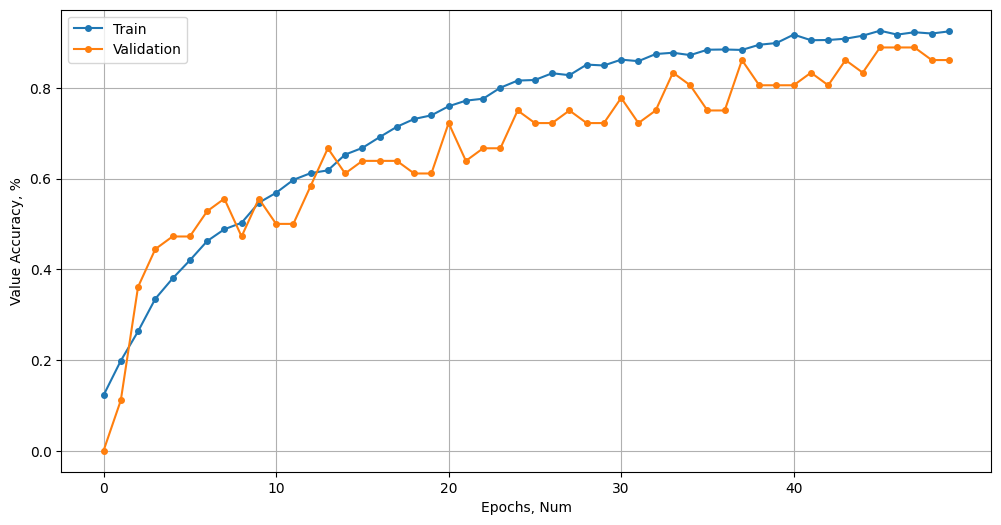

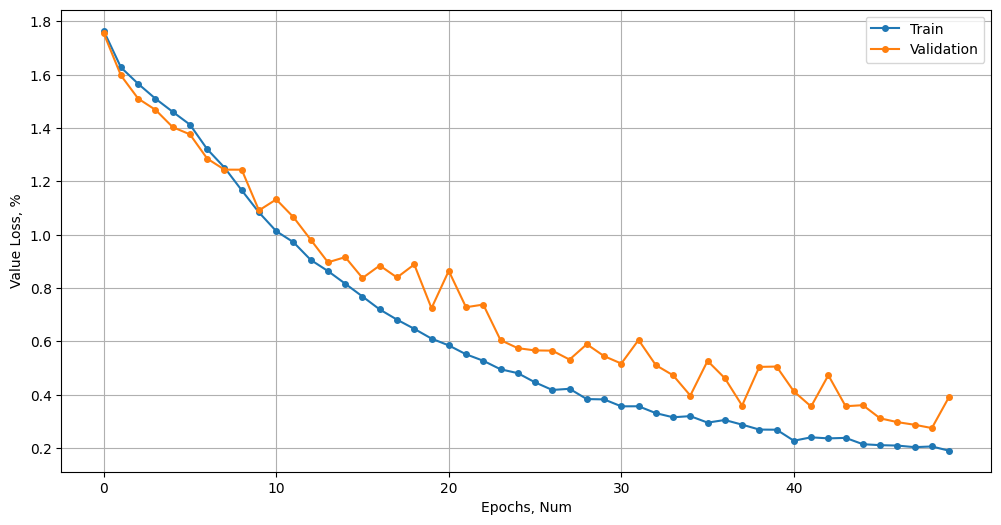

BEST MODEL 46_acc_0.89.h5
Found 50 images belonging to 5 classes.
50/50 [==============================] - 1s 7ms/step


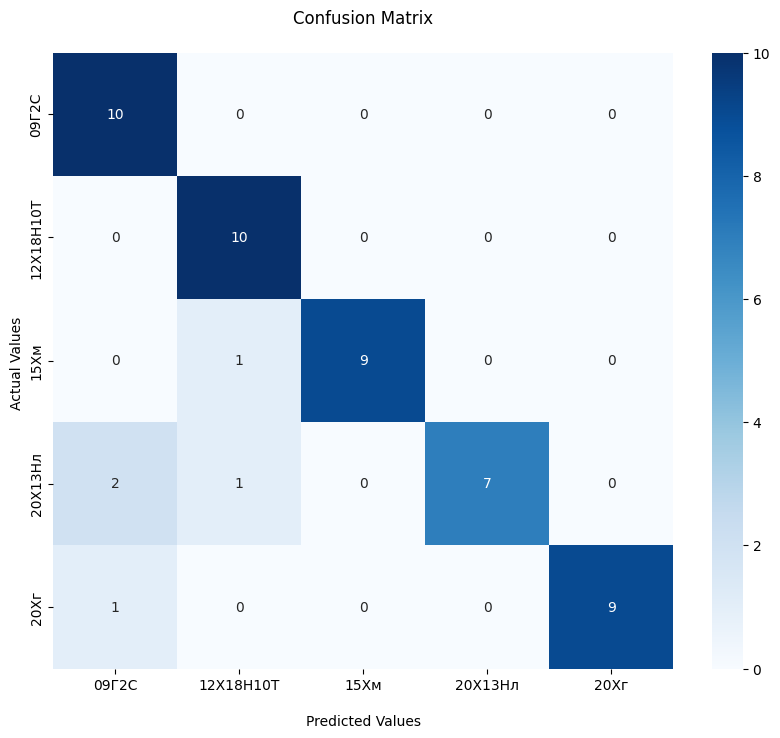

              precision    recall  f1-score   support

       09Г2С       0.77      1.00      0.87        10
   12Х18Н10Т       0.83      1.00      0.91        10
        15Хм       1.00      0.90      0.95        10
     20Х13Нл       1.00      0.70      0.82        10
        20Хг       1.00      0.90      0.95        10

    accuracy                           0.90        50
   macro avg       0.92      0.90      0.90        50
weighted avg       0.92      0.90      0.90        50



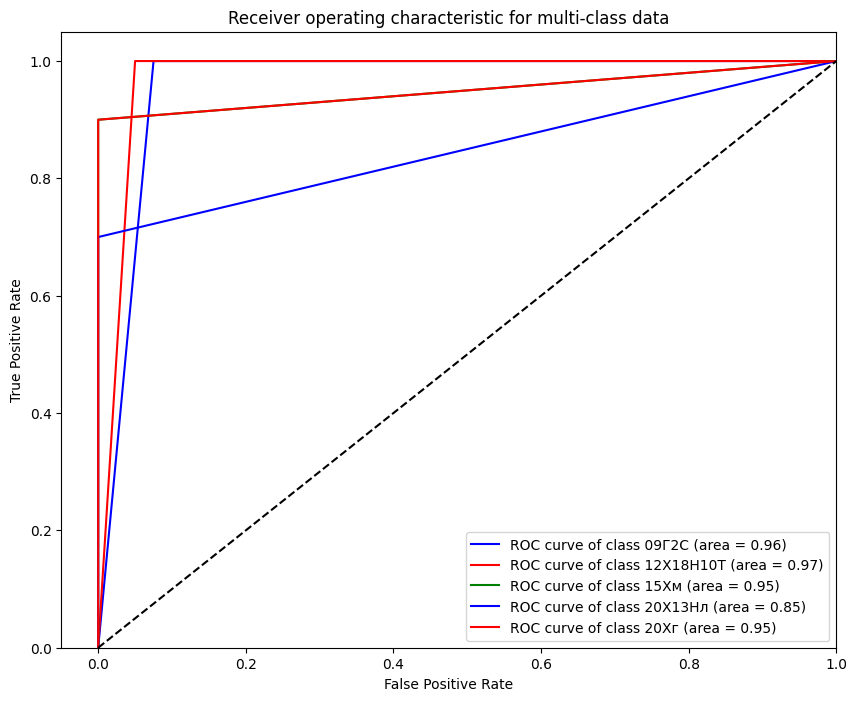

In [8]:

# Директория, в которую будут сохраняться лучшие эпохи обучения
  
# Балансировка весов в обучающей выборке при помощи пакета sklearn
"""
Балансировка весов помогает избежать "перевеса" НС в сторону одного из классов при неравномерном распределении количества данных в разных классах
"""
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
# Приведение к необходимому формату
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
print(class_weights)
# import pydotplus
# from keras.utils import plot_model
# plot_model(model, to_file='model_fvsdfg.png', show_shapes=True)
"""Запуск обучения НС"""
histoty = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // batch_size,
    class_weight=class_weights,
    callbacks=[build_callbacks()]
)